In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
max_iteration = 30000
weight_decay = 0.01
NUM_EMPLOYEES = 11000
NUM_VAL = 1000
Upsilon_1 = 0.01
Upsilon_2 = 0.01
NUM_FEATURES = 20
BANDWIDTH = 1

In [15]:
X = np.random.normal(loc=0.0, scale=10.0, size=(NUM_EMPLOYEES, NUM_FEATURES)) # the training set

survival_times = np.zeros(NUM_EMPLOYEES) # the surivial time of each employees
for i in range(NUM_EMPLOYEES):
    age = np.random.exponential(np.sum(Upsilon_1 * X[i,:]**2)+np.sum(Upsilon_2 * X[i,:]), size=1)
    survival_times[i] = np.ceil(age)
    
maximum_ob_time = int(max(survival_times))   

Y = np.ones((NUM_EMPLOYEES, maximum_ob_time)) # the lifetime matrix of all employees, if one employee leave at the time interval k, then from Y[i,k](inlcude)  all entries are -1
for i in range(NUM_EMPLOYEES):
    Y[i, int(survival_times[i])-1:] = -1
    
square = np.sum(X ** 2, axis=1)
column_vec = square[:, np.newaxis]
row_vec = square[np.newaxis, :]
Gaussian_Kernel = np.exp(-1 * (-2 * X.dot(X.T) + column_vec + row_vec) / (2 * BANDWIDTH ** 2)) # the Gaussian Kernel 
# Gaussian_Kernel = X.dot(X.T)

In [20]:
X_train = X[:-NUM_VAL]
X_val = X[-NUM_VAL:]
survival_training = survival_times[:-NUM_VAL]
survival_val = survival_times[-NUM_VAL:]
Y_train = Y[:-NUM_VAL]
Y_val = Y[-NUM_VAL:]
Gaussian_Kernel_Train = Gaussian_Kernel[:-NUM_VAL,:-NUM_VAL]
Gaussian_Kernel_Val = Gaussian_Kernel[-NUM_VAL:,-NUM_VAL:]

In [21]:
print(Y.shape)
print(maximum_ob_time)


(11000, 226)
226


the iteration is: 0
the accuracy is: 0.000863728813559322
the c-index is, 0.0007661096519752513
the iteration is: 2000
the accuracy is: 0.798344406779661
the c-index is, 0.49917895111369326
the iteration is: 4000
the accuracy is: 0.8749840677966102
the c-index is, 0.585716624702676
the iteration is: 6000
the accuracy is: 0.910784406779661
the c-index is, 0.6551769866920538
the iteration is: 8000
the accuracy is: 0.9341959322033898
the c-index is, 0.7129440820463142
the iteration is: 10000
the accuracy is: 0.9489715254237289
the c-index is, 0.7623125190926675
the iteration is: 12000
the accuracy is: 0.9603440677966102
the c-index is, 0.8036564802274825
the iteration is: 14000
the accuracy is: 0.9687325423728813
the c-index is, 0.835127214004933
the iteration is: 16000
the accuracy is: 0.9741718644067796
the c-index is, 0.8616443799586767
the iteration is: 18000
the accuracy is: 0.9799379661016949
the c-index is, 0.8870697646945406
0.8373


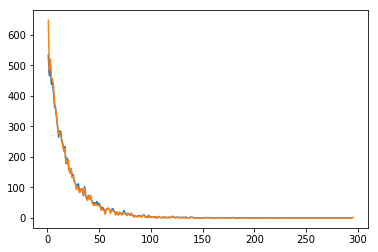

In [7]:
alpha = np.zeros_like(Y_train)
max_iteration = 20000
for t in range(max_iteration):
    index = int(np.floor(np.random.rand()*NUM_EMPLOYEES)) # randomly select one employee
    haty_index = (Gaussian_Kernel[index,:][np.newaxis,:].dot(alpha * Y)).reshape(-1) # calculate the predicted y vector
    haty_index /= (t+1) * weight_decay

    ## update alpha

    mask = Y[index,:]*haty_index < 1
    alpha[index,] += mask

    if t%2000 == 0:
        print("the iteration is:", t)
        hatY = np.zeros_like(Y)
        hatY += Gaussian_Kernel.T.dot(alpha*Y)
        hatY /= (t+1) * weight_decay
        predict_age = np.zeros(NUM_EMPLOYEES)
        for i in range(NUM_EMPLOYEES):
            predict_age[i] = np.sum(hatY[i,:] > 0 )+1
        
        acc = np.sum(Y*hatY > 0)/(NUM_EMPLOYEES *maximum_ob_time)
        print("the accuracy is:", acc)
        
        useful_pair = 0
        denominator = NUM_EMPLOYEES*(NUM_EMPLOYEES-1)/2
        
        for i in range(NUM_EMPLOYEES):
            for j in np.arange(NUM_EMPLOYEES-(i+1))+(i+1):
                if (survival_times[i]-survival_times[j])*(predict_age[i]-predict_age[j])> 0: # useful pair
                    useful_pair += 1
                if  survival_times[i] == survival_times[j]: # pair contains two employees whose lifetime are identical
                    denominator -= 1
        
        c_index = useful_pair/ denominator
        print("the c-index is,",c_index)
        
print(np.sum(predict_age == survival_times)/NUM_EMPLOYEES)        
x_axis = np.arange(maximum_ob_time)+1
y_axis = np.zeros(maximum_ob_time)
y_predict_axis = np.zeros(maximum_ob_time)

for i in range(maximum_ob_time):
    y_axis[i] = np.sum(survival_times == x_axis[i])
    y_predict_axis[i] = np.sum(predict_age == x_axis[i])
print
plt.plot(x_axis, y_axis, x_axis,y_predict_axis)


In [ ]:
print(alpha)
for i in range(maximum_ob_time):
    print(np.sum(Y[:,i] == -1)/NUM_EMPLOYEES)
print(survival_times.mean(),survival_times.std())
# print(predict_age.mean(),predict_age.std())

In [ ]:
print(Y)
hatY = np.zeros_like(Y)
hatY += Gaussian_Kernel.T.dot(alpha*Y)
hatY /= (t+1) * weight_decay
print(hatY)

In [ ]:
print(Gaussian_Kernel)
print(np.sum(Gaussian_Kernel,axis=0))

In [ ]:
print(Y)
print(survival_times)
print(predict_age)
# for i in np.arange(NUM_EMPLOYEES):
    

In [ ]:
print(alpha)